In [1]:
# 계산프래프

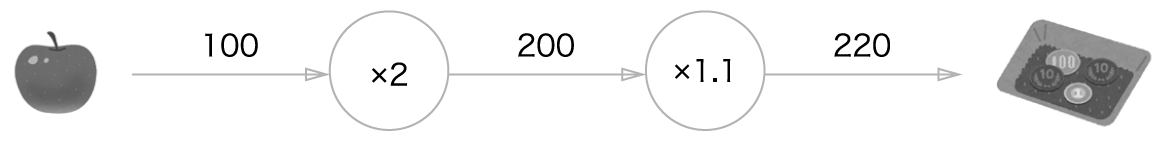

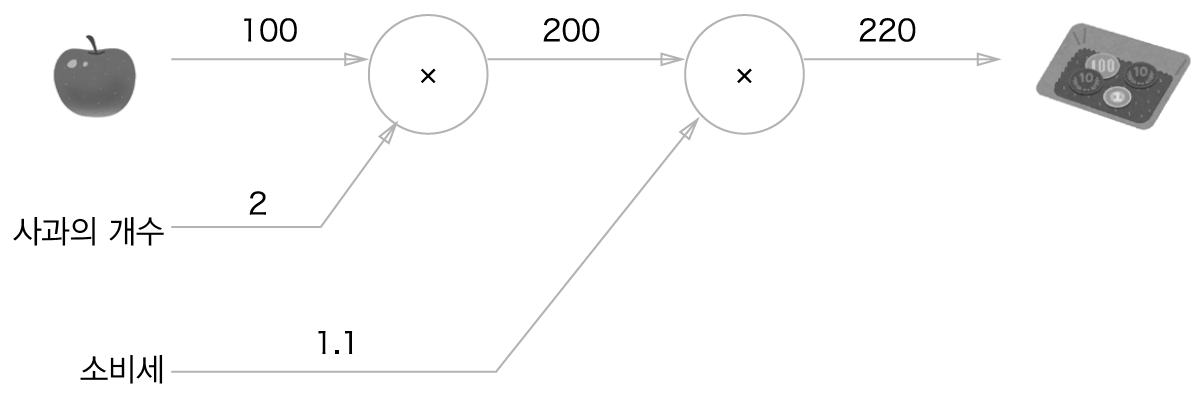

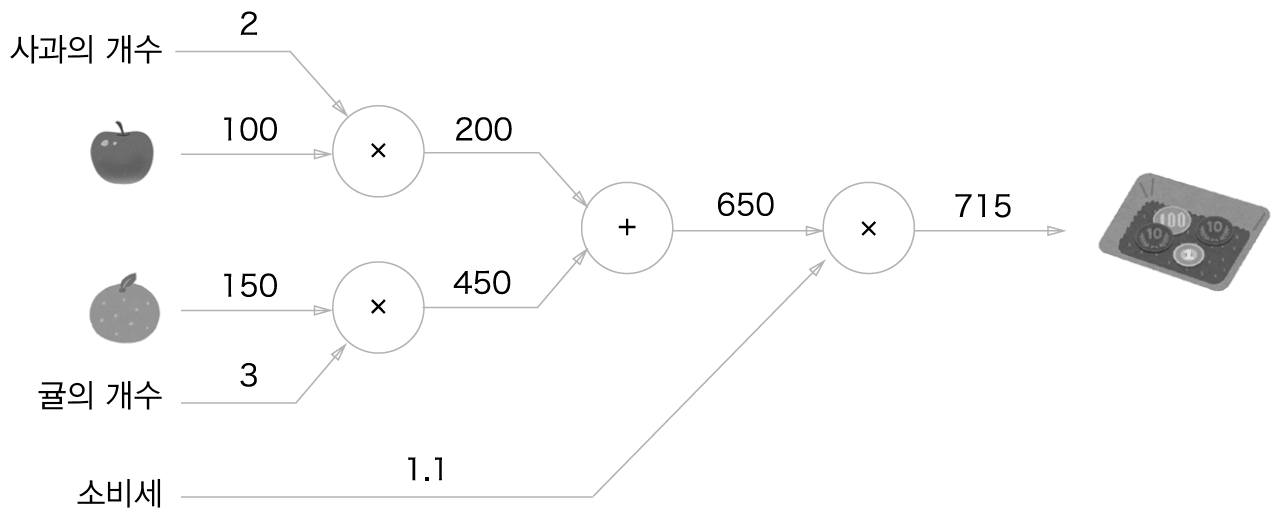

In [2]:
# 역전파
# 국소적 계산

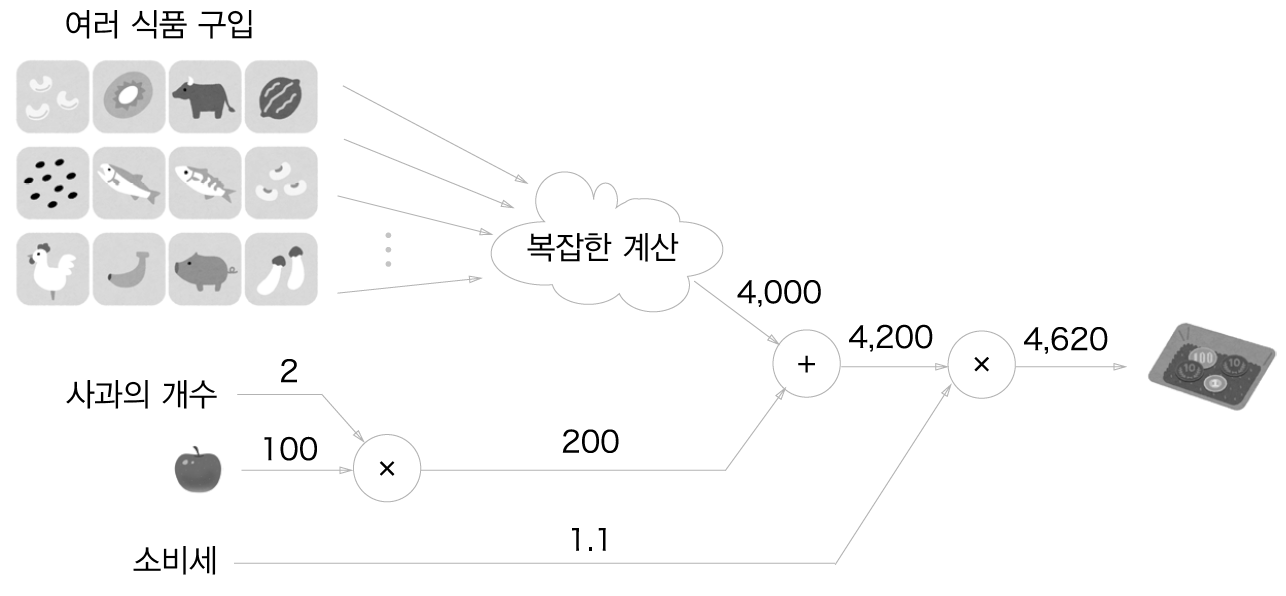

In [3]:
# 계산그래프는 국소적 계산에 집중
#역전파에 의한 미분 값의 전달

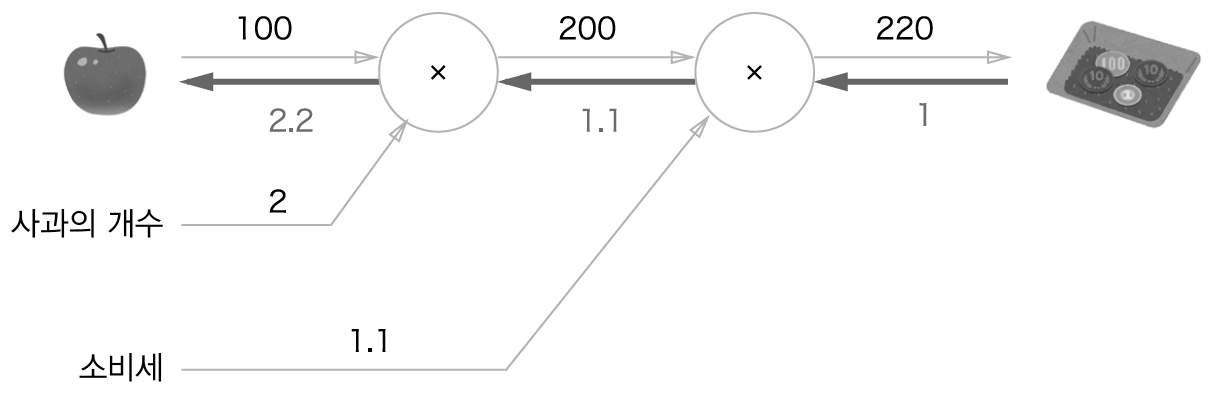

In [4]:
#계산그래프의 역전파

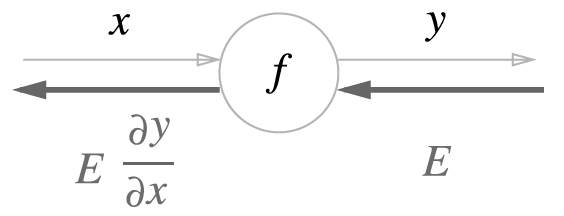

In [5]:
# 합성함수  : 여러개의 함수로 이루어진 함수
# z = (x+y)**2

# z = t**2
# t = x+y

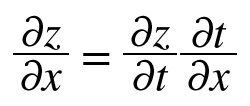

In [6]:
# 위의 식을 국소적 미분(편미분)을 하면

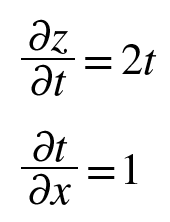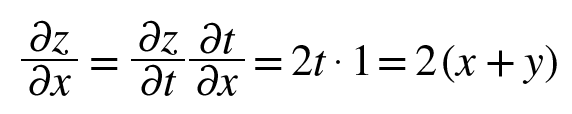

In [7]:
# 그래프로 표현

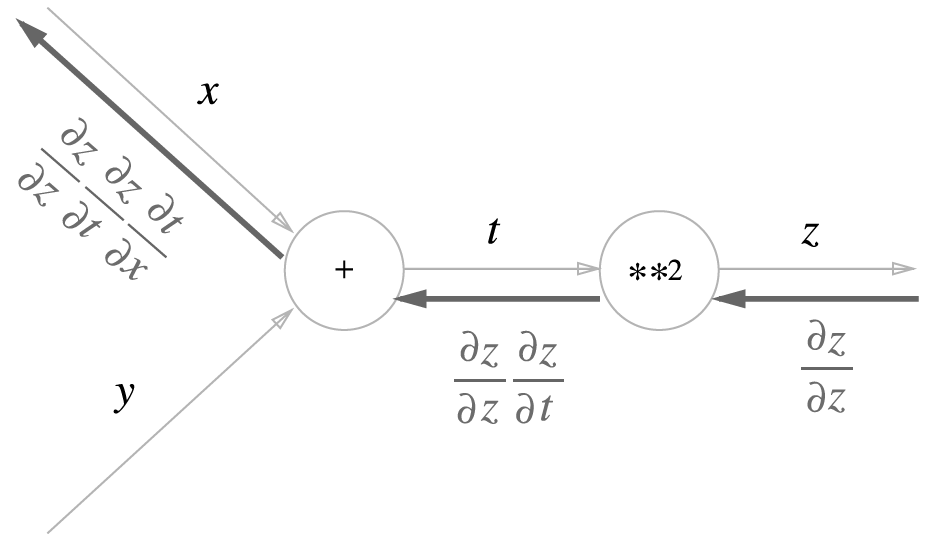

In [8]:
class MultiLayer:
    def __init__(self):
        self.x = None
        self.y = None
    def forward(self, x,y):
        self.x = x
        self.y = y
        out = x * y
        return out
    def backward(self,dout):
        dx = dout*self.y  # x와 y를변경
        dy = dout*self.x
        return dx, dy

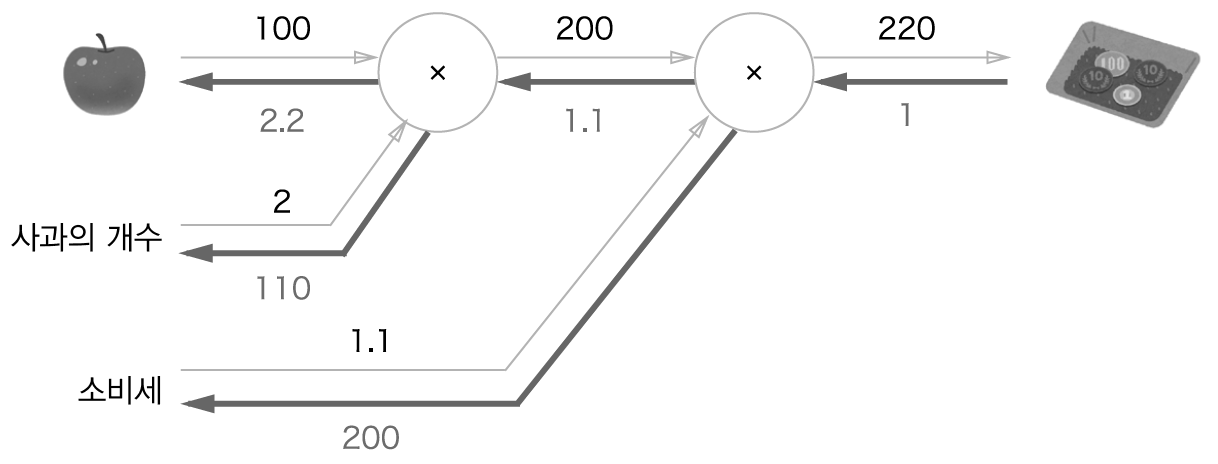

In [9]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MultiLayer()
mul_tax_layer = MultiLayer()

# 순전파 
apple_price = mul_apple_layer.forward(apple,apple_num)
price = mul_tax_layer.forward(apple_price,tax)

price

220.00000000000003

In [10]:
# 역전파
dprice = 1
dapple_price, dtax =  mul_tax_layer.backward(dprice)
dapple, dapple_num =  mul_apple_layer.backward(dapple_price)

In [11]:
dapple,dapple_num,dtax

(2.2, 110.00000000000001, 200)

In [12]:
class AddLayer:
    def __init__(self):
        pass
    def forward(self, x, y):
        return x + y
    def backward(self, dout):
        dx = dout*1
        dy = dout*1
        return dx, dy

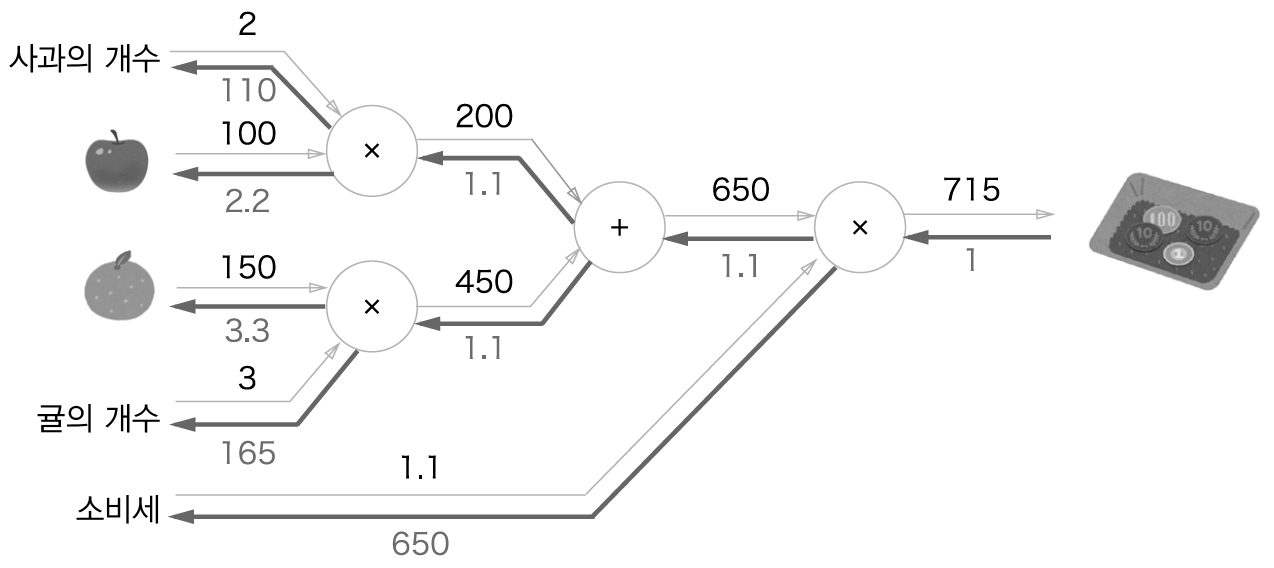

In [13]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

mul_apple_layer = MultiLayer()
mul_orange_layer = MultiLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MultiLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple,apple_num)
orange_price = mul_orange_layer.forward(orange,orange_num)
all_price = add_apple_orange_layer.forward(apple_price,orange_price)
price= mul_tax_layer.forward(all_price,tax)
price

715.0000000000001

In [14]:
dprice = 1
dall_price,dtax = mul_tax_layer.backward(dprice)
dapple_price,dorange_price = add_apple_orange_layer.backward(dall_price)
dorange,dorange_num = mul_orange_layer.backward(dorange_price)
dapple,dapple_num = mul_apple_layer.backward(dapple_price)

In [15]:
dapple_num, dapple, dorange, dorange_num, dtax

(110.00000000000001, 2.2, 3.3000000000000003, 165.0, 650)

In [16]:
# 렐루 , 시그모이드 층으로 구성

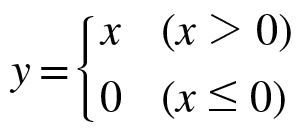

In [17]:
# x에 대한 y의 미분

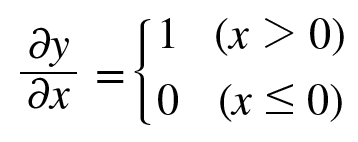

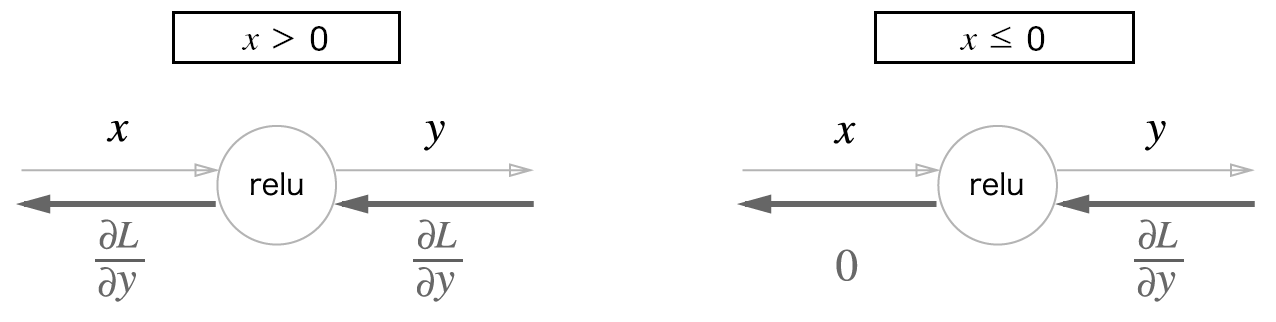

In [18]:
class Relu:
    def __init__(self):
        self.mask = None
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

In [19]:
# sigmoid 계층의 계산 그래프(순전파)

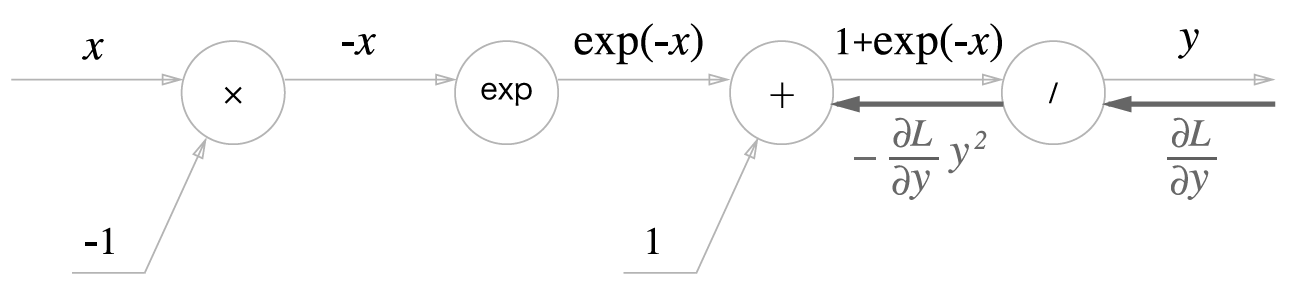

In [20]:
# exp 노드는 y=exp(x)   / 노드는 y = 1/x
# y = 1/x 미분하면

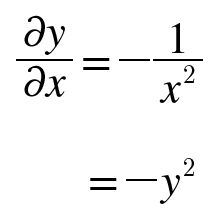

In [21]:
# 상류에서 흘러온 값에 -(y**2)  순전파의 출력에 제곱한후 마이너스를 붙인 값

In [22]:
# y = exp(x)

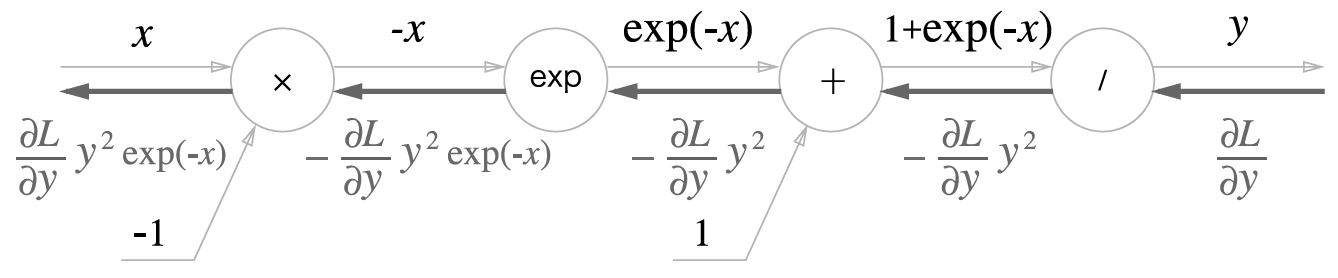

In [23]:
class Sigmoid:
    def __init__(self):
        self.out = None
    def forward(self, x):
        out = 1 / (1+np.exp(-x))
        self.out = out
        return out
    def backward(self, dout):
        dx = dout * (1.0-self.out)*self.out
        return dx

In [24]:
# x , w , b 행렬

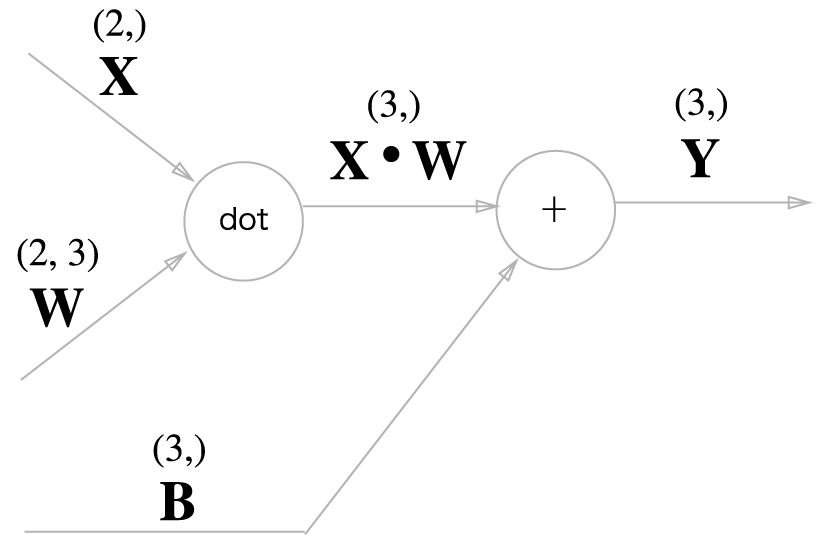

In [25]:
import numpy as np

In [26]:
x = np.random.randn(2)
w = np.random.randn(2,3)
b = np.random.randn(3)
y = np.dot(x,w)+b

In [40]:
class Affine:
    def __init__(self,w,b):
        self.w = w
        self.b = b
        self.x = None
        self.dw = None
        self.db = None
    def forward(self, x):
        self.x = x
        out = x@self.w + self.b
        return out
    def backward(self, dout):
        dx = np.dot(dout, self.w.T) 
        self.dw = np.dot(self.x.T, dout)
        self.db = np.sum(dout,axis=0)
        return dx

In [41]:
w

array([[-0.65095697, -0.41605542, -1.51367668],
       [ 0.57537863, -0.80761864,  0.62821262]])

In [29]:
w.T

array([[-0.65095697,  0.57537863],
       [-0.41605542, -0.80761864],
       [-1.51367668,  0.62821262]])

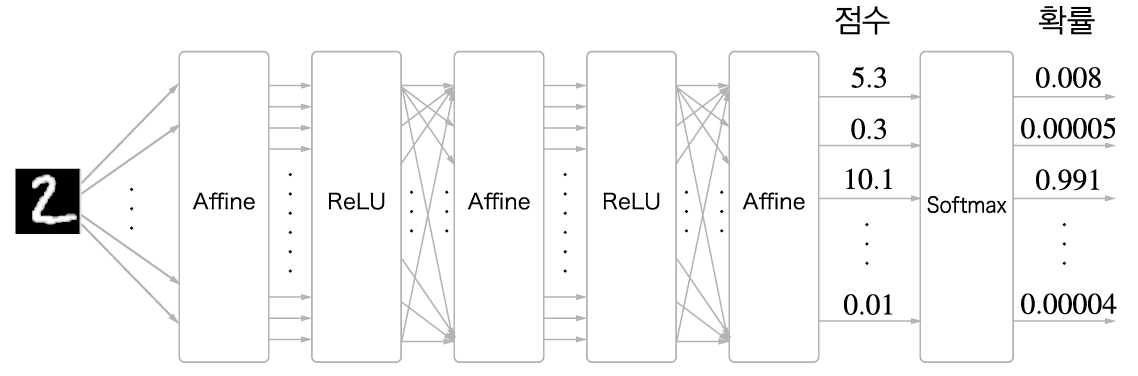

In [30]:
# softmax with loss

In [31]:
from common import *

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None #손실
        self.y = None # softmax 출력
        self.t = None # 정답 레이블(원 핫 벡터)
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

In [32]:
# 오류역전파 구현
# 1 미니배치
# 2 기울기 산출 : 각 가중치 매개변수의 기울기--> 손실함수의 값을 가장 작게하는 방향
# 3 매개변수 갱신 : 기울기 방향으로 조금씩 갱신
# 1-3반복

In [33]:
# 오류역전파를 적용한 신경망
from collections import OrderedDict
class TwoLayerNet:
    def __init__(self, input_size, hidden_size,output_size,weight_init_std = 0.01):
        # 가중치 초기화
        self.params ={}  # 신경망의 매개변수 보관
        self.params['w1'] = weight_init_std * np.random.randn(input_size,hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['w2'] = weight_init_std * np.random.randn(hidden_size,output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'],self.params['b1'])
        self.layers['relu'] = Relu()
        self.layers['Affine2'] = Affine(self.params['w2'],self.params['b2'])
        self.lastlayer = SoftmaxWithLoss()
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastlayer.forward(y,t)
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 :
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy
# 기울기
    def numeric_gradient(self, x, t):
        loss_w = lambda w : self.loss(x,t)
        grads = {}
        grads['w1'] = numeric_gradient(loss_w,self.params['w1'])
        grads['b1'] = numeric_gradient(loss_w,self.params['b1'])
        grads['w2'] = numeric_gradient(loss_w,self.params['w2'])
        grads['b2'] = numeric_gradient(loss_w,self.params['b2'])
        return grads
    def gradient(self,x,t):
        # 순전파
        self.loss(x,t)
        # 역전파
        dout = 1
        dout = self.lastlayer.backward(dout)        
        layers = list(self.layers.values())
        layers.reverse()        
        for layer in layers:            
            dout = layer.backward(dout)
        
        # 결과 저장
        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        
        return grads
        
    
        

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = loadMnist(nomalize=True, flatten=True, onehotEncording=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 1000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 5000   # 미니배치 크기
learning_rate = 0.001

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in tqdm(range(iters_num)):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 오차역전파기법으로 기울기를 구한다
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('w1', 'b1', 'w2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc , train loss| " + str(train_acc) + ", " + str(test_acc)+","+str(loss) )

  0%|▏                                                                                | 2/1000 [00:00<03:45,  4.42it/s]

train acc, test acc , train loss| 0.09656666666666666, 0.0951,10.814934784316943


  1%|█                                                                               | 14/1000 [00:01<02:23,  6.85it/s]

train acc, test acc , train loss| 0.10005, 0.0992,10.81485774687397


  3%|██▏                                                                             | 27/1000 [00:03<02:09,  7.51it/s]

train acc, test acc , train loss| 0.10285, 0.1022,10.81489911845006


  4%|███                                                                             | 38/1000 [00:04<02:10,  7.40it/s]

train acc, test acc , train loss| 0.10558333333333333, 0.1049,10.814756084060884


  5%|████                                                                            | 50/1000 [00:06<02:10,  7.28it/s]

train acc, test acc , train loss| 0.1079, 0.1077,10.814671246455031


  6%|█████                                                                           | 63/1000 [00:07<01:59,  7.86it/s]

train acc, test acc , train loss| 0.11113333333333333, 0.1103,10.814736798820519


  7%|█████▉                                                                          | 74/1000 [00:09<02:19,  6.64it/s]

train acc, test acc , train loss| 0.1134, 0.1122,10.81460609840977


  9%|██████▉                                                                         | 86/1000 [00:10<02:30,  6.07it/s]

train acc, test acc , train loss| 0.11586666666666667, 0.115,10.81456150909471


 10%|███████▊                                                                        | 98/1000 [00:12<02:59,  5.03it/s]

train acc, test acc , train loss| 0.11818333333333333, 0.1164,10.814443222552365


 11%|████████▋                                                                      | 110/1000 [00:14<02:25,  6.12it/s]

train acc, test acc , train loss| 0.12093333333333334, 0.1185,10.814395639975436


 12%|█████████▋                                                                     | 122/1000 [00:15<02:21,  6.21it/s]

train acc, test acc , train loss| 0.12398333333333333, 0.1207,10.814347782064003


 13%|██████████▌                                                                    | 134/1000 [00:17<02:48,  5.14it/s]

train acc, test acc , train loss| 0.12605, 0.1228,10.814291455237338


 15%|███████████▌                                                                   | 146/1000 [00:19<03:04,  4.63it/s]

train acc, test acc , train loss| 0.1288, 0.1247,10.81431740153314


 16%|████████████▍                                                                  | 158/1000 [00:21<02:46,  5.05it/s]

train acc, test acc , train loss| 0.13153333333333334, 0.1258,10.814207401232105


 17%|█████████████▌                                                                 | 171/1000 [00:22<01:58,  7.02it/s]

train acc, test acc , train loss| 0.13408333333333333, 0.1274,10.813970865370822


 18%|██████████████▍                                                                | 182/1000 [00:24<02:03,  6.65it/s]

train acc, test acc , train loss| 0.1365, 0.13,10.814167010544542


 20%|███████████████▍                                                               | 195/1000 [00:26<01:53,  7.10it/s]

train acc, test acc , train loss| 0.13878333333333334, 0.132,10.813944079926097


 21%|████████████████▎                                                              | 207/1000 [00:27<01:44,  7.57it/s]

train acc, test acc , train loss| 0.14108333333333334, 0.1342,10.813855634038541


 22%|█████████████████▏                                                             | 218/1000 [00:29<01:47,  7.29it/s]

train acc, test acc , train loss| 0.14353333333333335, 0.137,10.814009029912127


 23%|██████████████████▏                                                            | 231/1000 [00:30<01:48,  7.06it/s]

train acc, test acc , train loss| 0.14575, 0.1392,10.813750612306798


 24%|███████████████████                                                            | 242/1000 [00:32<02:08,  5.92it/s]

train acc, test acc , train loss| 0.14805, 0.1409,10.813621844317986


 25%|███████████████████▉                                                           | 252/1000 [00:33<01:39,  7.54it/s]


KeyboardInterrupt: 

In [45]:
# SGD(확률적 경사하강법)

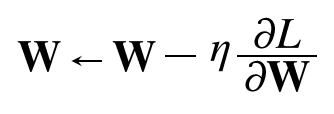

In [46]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
    def update(self, params, grads):  # 업데이트 하려는 파라메터와 기울기를 전달받는다
        for key in params.keys():
            params[key] -= lr*grads[key]

In [47]:
# SGD의 단점

In [48]:
# 미분... 기울기 최소값을 구하는 과정  
# y축방향은 가파르고 x축방향을 완만한 상태

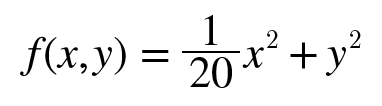

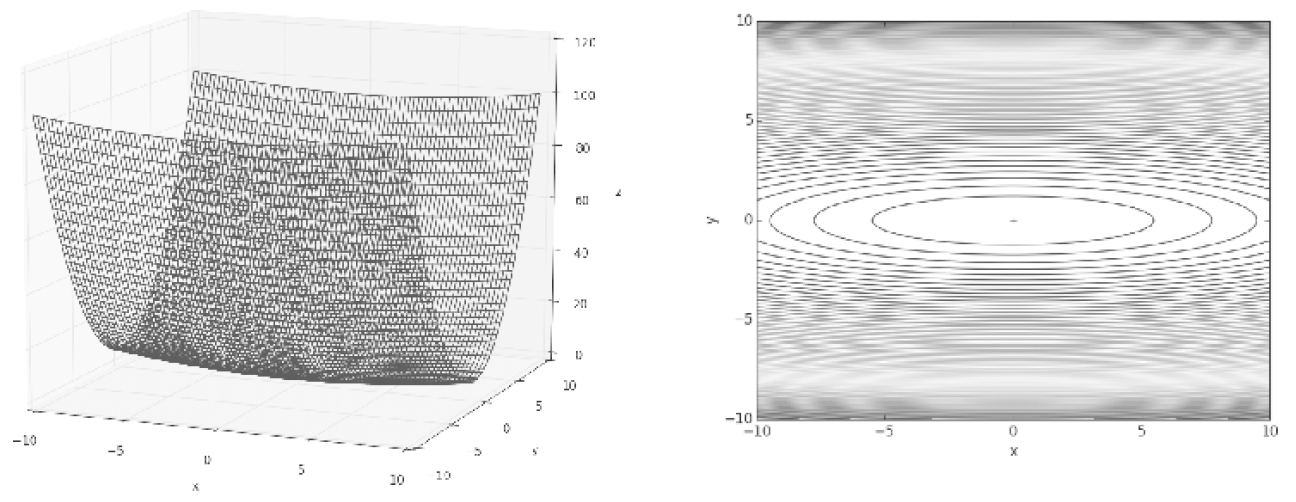

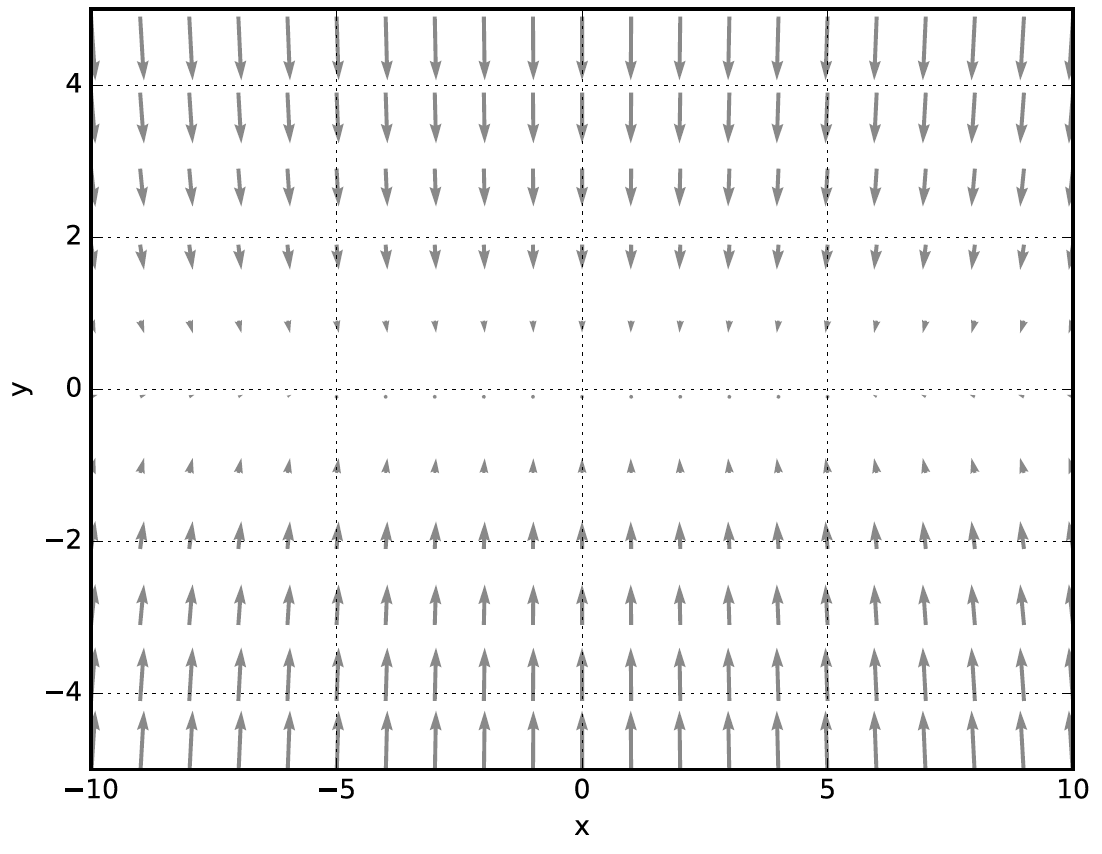

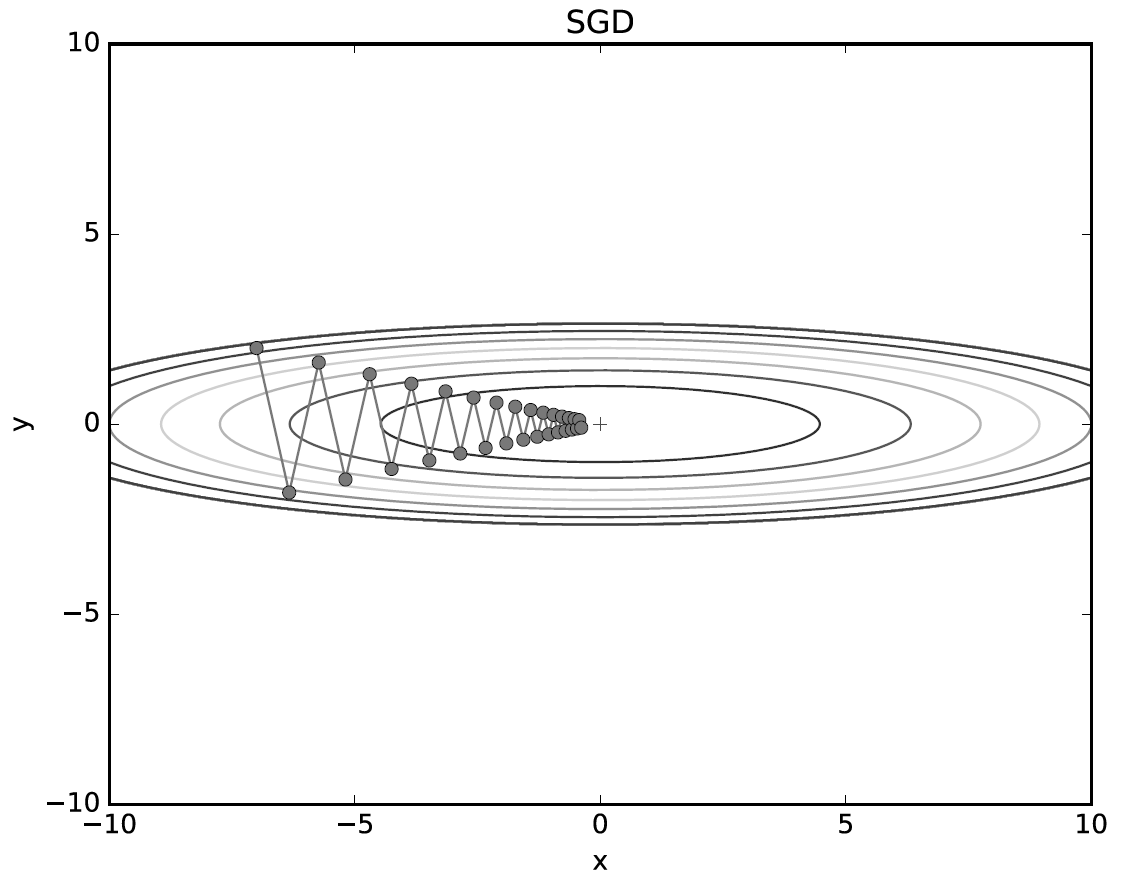

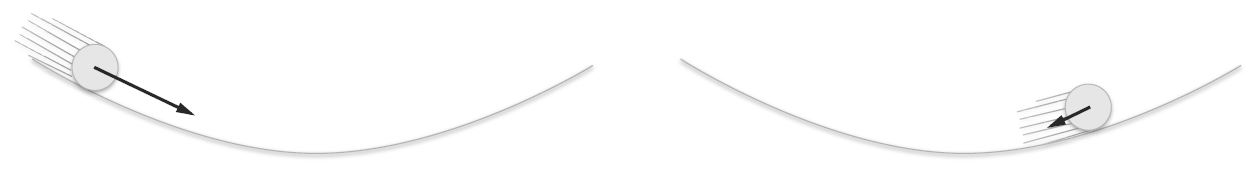

In [ ]:
(-7.0, 2.0)
# 최적화 개선  1. 학습률, 2. momentum 

In [ ]:
# 모멘텀을 이용한 최적화

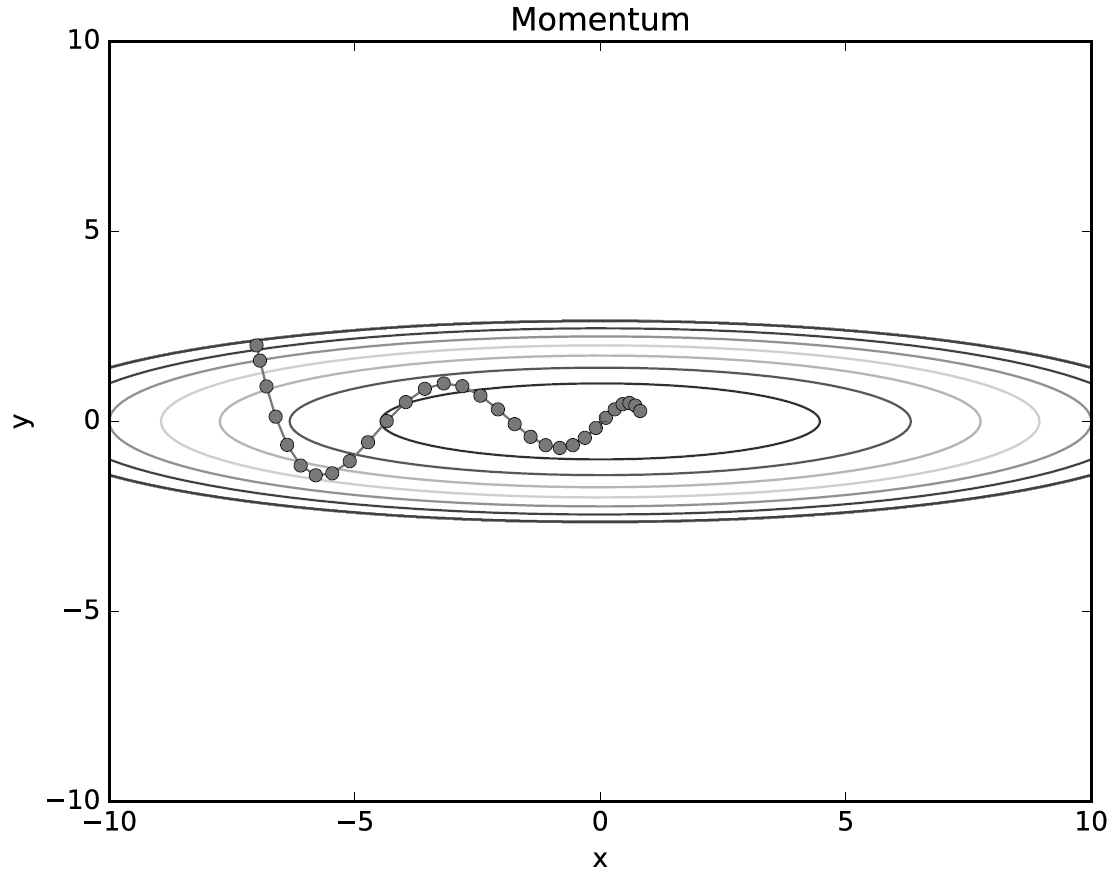

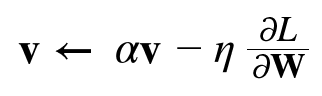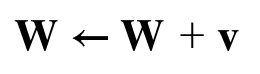

In [49]:
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*self.grads[key]
            params[key] += self.v[key]            

In [50]:
# Adagrade

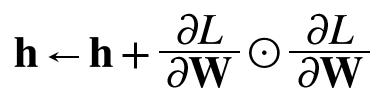

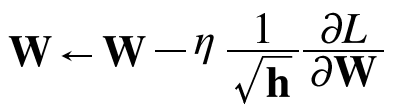

In [51]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key]*grads[key]
            params[key] -= self.lr*grads[key] / (np.sqrt(self.h[key])+ 1e-7)

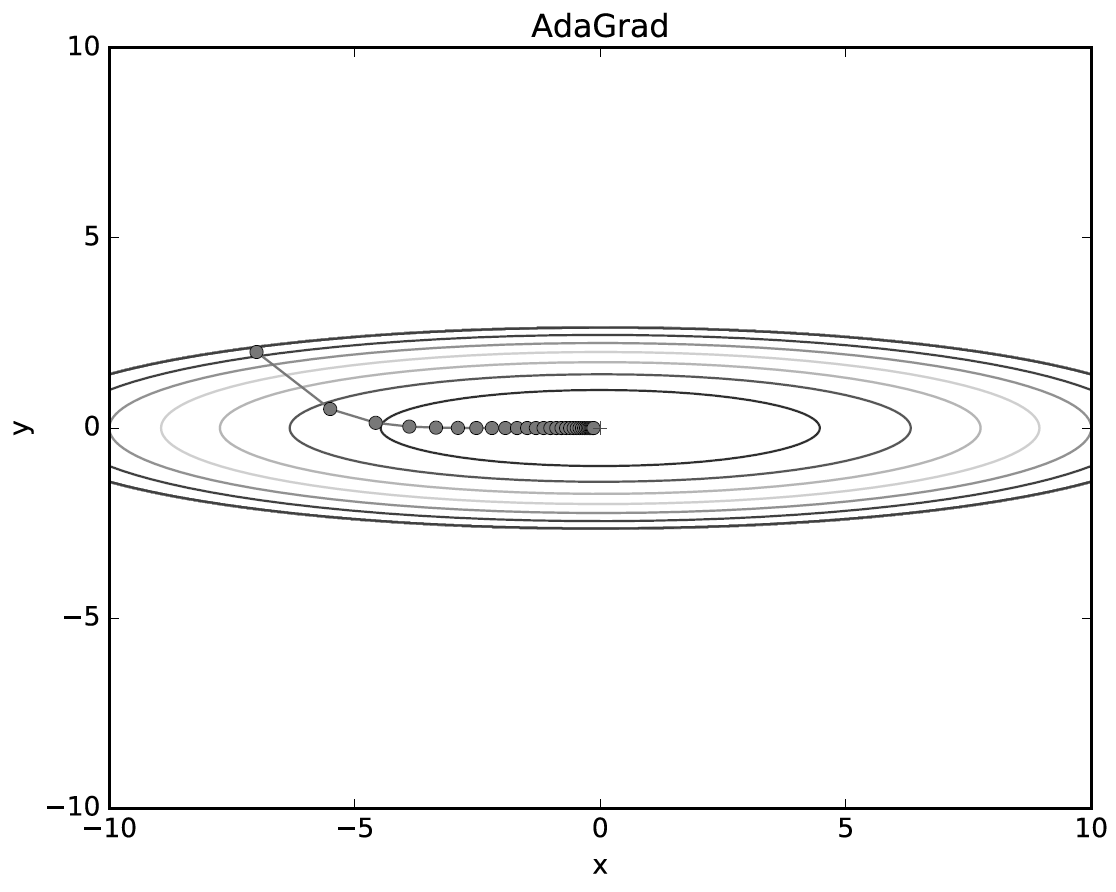

In [52]:
# Adam = momentum + AdaGrad

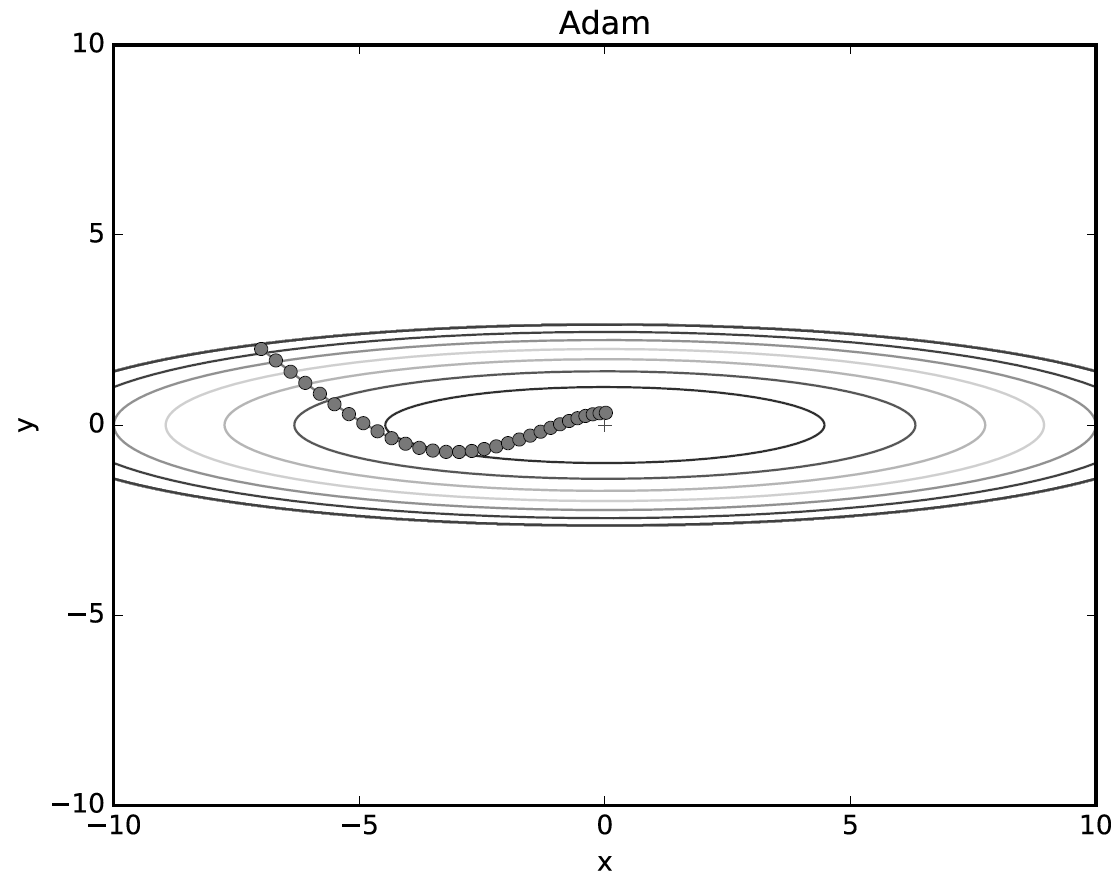

In [53]:
# 신경망 학습에서 중요한 요소

In [54]:
# 가중치를 0으로 설정 : 모든가중치가 같다. ->  오류역전파에서 모든 가중치가 똑같이 갱신

In [55]:
# 각 층의 활성화값이 적당히퍼지게..... 이걸 강제로 적당히 퍼트리는것.... 배치 정규화 2015

In [ ]:
# 학습속도 개선
# 초기값에 크게 의존하지 않아도 됨
# 오버피팅을 억제(드랍아웃을 좀 적게 사용해도 됨)

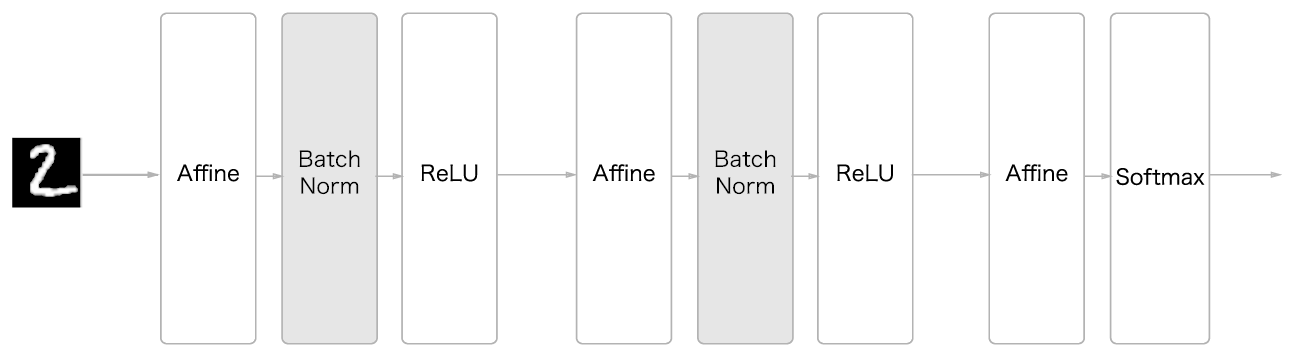

In [56]:
# 배치 정규화 : 데이터 분포가 평균이 0  분산이 1이되도록 정규화